In [1]:
import myqengine as qe
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#Get all current Mutual funds who hold NVDA
univ = qe.id_universe(ids = ['NVDA-US'],universe_type ='Equity')
time_series = qe.time_series(start_date='0M',end_date = '0M')
formulas = ['OS_TOP_HLDR_ID(ALL,#DATE,,M,,M)','OS_TOP_HLDR_NAME(ALL,#DATE,,M,,M,,"EN")','OS_TOP_HLDR_MV(ALL,#DATE,,M,,M,SEC,USD)']
q_req = qe.calculate(universe=univ, dates = time_series, formulas=formulas,is_array_return_type=True,source= 'FqlExpression')
df_temp = q_req.data.copy()

#clean up table
df_temp.rename(columns ={'OS_TOP_HLDR_ID(ALL,#DATE,,M,,M)':'hldr_id',
                    'OS_TOP_HLDR_NAME(ALL,#DATE,,M,,M,,"EN")':'hldr_name',
                    'OS_TOP_HLDR_MV(ALL,#DATE,,M,,M,SEC,USD)':'mv'},inplace=True)
                    


In [2]:
df = pd.concat([df_temp['hldr_id'].explode() ,df_temp['hldr_name'].explode(),df_temp['mv'].explode()],axis=1)
df.set_index('hldr_id',inplace=True)
df.head()

,hldr_name,mv
hldr_id,,
M4004630,Vanguard Total Stock Market ETF,34196140611.130001
M4004543,Vanguard 500 Index Fund,27676648381.68
M4001597,Fidelity 500 Index Fund,13049993344.01
M4006564,SPDR S&P 500 ETF Trust,13019070428.26
M4032427,Government Pension Fund - Global (The),12366990597.76


In [3]:
#Get Fund AUM
fund_univ = qe.id_universe(ids = df.index.to_list(),universe_type ='Equity')
time_series = qe.time_series(start_date='0M',end_date = '0M')

formulas = ['OS_HLDR_MSTYLE','OS_HLDR_MF_FAMILY','STRING(FIRST_ITEM_AV(OS_FUND_TICKER))','FFD_AUM(#DATE,,M,USD)']

q_req = qe.calculate(universe=fund_univ, dates = time_series, formulas=formulas,source= 'FqlExpression')
q_req.data

,DATE,UNIVERSE,OS_HLDR_MSTYLE,OS_HLDR_MF_FAMILY,STRING(FIRST_ITEM_AV(OS_FUND_TICKER)),"FFD_AUM(#DATE,,M,USD)"
0,20230731,M4004630,Generalist,Vanguard Funds,VTSMX,1.393315e+12
1,20230731,M4004543,Generalist,Vanguard Funds,VFINX,9.205360e+11
2,20230731,M4001597,Index,@NA,FXAIX,4.327432e+11
3,20230731,M4006564,Generalist,SPDR Funds,SPY,4.320715e+11
4,20230731,M4032427,Generalist,@NA,@NA,1.490733e+12
...,...,...,...,...,...,...
5635,20230731,M26119964,Growth,@NA,@NA,1.269686e+08
5636,20230731,M25844375,Generalist,@NA,@NA,2.614712e+06
5637,20230731,M18815022,Generalist,Canada Life Funds,@NA,5.107436e+08
5638,20230731,M24430493,Generalist,@NA,@NA,1.792876e+05


In [4]:

dff = q_req.data.copy()
dff.rename(columns= {"UNIVERSE":"hldr_id",
                    'OS_HLDR_MSTYLE':'style',
                    'OS_HLDR_MF_FAMILY':'fund_family',
                    'STRING(FIRST_ITEM_AV(OS_FUND_TICKER))':'ticker',
                    'FFD_AUM(#DATE,,M,USD)':'aum',
                    },inplace=True)
dff.set_index(['hldr_id'],inplace=True)

#join datasets
df = df.join(dff,how='left')

df['weight'] = df['mv']/df['aum']

df['fund_family']=df['fund_family'].replace('@NA','Other')
df['style']=df['style'].replace('@NA','Other')
df = df[df['ticker']!='@NA']
df[df['ticker']!='']
df = df.replace('',np.nan)
df = df.dropna()


In [5]:
#Get Fund AUM
fund_univ = qe.id_universe(ids = df['ticker'].to_list(),universe_type ='Equity')
time_series = qe.time_series(start_date='0M',end_date = '0M')

formulas = ['FFD_CLASS_CAT(TEXT)','FFD_CLASS_FOCUS(TEXT)','FFD_CLASS_NICHE(TEXT)','P_PRICE_RETURNS(1,0,-1/0/0,USD)','P_PRICE_RETURNS(1,12/31/0,0,USD)','P_PRICE_RETURNS(1,0/0/-1,0,USD)']

q_req = qe.calculate(universe=fund_univ, dates = time_series, formulas=formulas,source= 'ScreeningExpression')
q_req.data

,DATE,UNIVERSE,FFD_CLASS_CAT(TEXT),FFD_CLASS_FOCUS(TEXT),FFD_CLASS_NICHE(TEXT),"P_PRICE_RETURNS(1,0,-1/0/0,USD)","P_PRICE_RETURNS(1,12/31/0,0,USD)","P_PRICE_RETURNS(1,0/0/-1,0,USD)"
0,20230731,VTSMX,Size and Style,Total Market,Broad-based,3.56942,-4.30127,12.231800
1,20230731,VFINX,Size and Style,Large Cap,Broad-based,3.20239,-3.86757,12.583300
2,20230731,FXAIX,Size and Style,Large Cap,Broad-based,3.19463,-3.84664,12.726200
3,20230731,SPY,Size and Style,Large Cap,Broad-based,3.27333,-3.89262,12.699900
4,20230731,IVV,Size and Style,Large Cap,Broad-based,3.24651,-3.86153,12.676500
...,...,...,...,...,...,...,...,...
4458,20230731,SGLC,Size and Style,Large Cap,Broad-based,4.59683,-4.25122,NaN
4459,20230731,HLGE,Sector,Theme,Consumer,3.76577,-5.18091,9.361200
4460,20230731,YPS,Size and Style,Large Cap,Broad-based,4.18373,-5.85577,6.585510
4461,20230731,FHSNX,Asset Allocation,Target Outcome,Income & Capital Appreciation,1.20000,-2.75001,0.423384


In [6]:

dff = q_req.data.copy()
dff.rename(columns= {"UNIVERSE":"ticker",
                    'FFD_CLASS_CAT(TEXT)':'category',
                    'FFD_CLASS_FOCUS(TEXT)':'focus',
                    'FFD_CLASS_NICHE(TEXT)':'niche',
                    'P_PRICE_RETURNS(1,0,-1/0/0,USD)':'tret_1m',
                    'P_PRICE_RETURNS(1,12/31/0,0,USD)':'tret_ytd',
                    'P_PRICE_RETURNS(1,0/0/-1,0,USD)':'tret_1y'
                    },inplace=True)

dff.drop(columns =['DATE'],inplace=True)
#dff[['ticker','category','focus']] = dff[['ticker','category','focus']].astype(str)
dff.set_index('ticker',inplace=True)
df = df.join(dff,how='left',on='ticker')
df['weight'] =df['mv'] /df['aum']

In [7]:
df = df.dropna()
df['category']=df['category'].replace('None','Other')
df['focus']=df['focus'].replace('None','Other')
df['niche']=df['niche'].replace('None','Other')
df = df[df['weight']<1]
df.head()

,hldr_name,mv,DATE,style,fund_family,ticker,aum,weight,category,focus,niche,tret_1m,tret_ytd,tret_1y
hldr_id,,,,,,,,,,,,,,
M4004630,Vanguard Total Stock Market ETF,3.419614e+10,20230731,Generalist,Vanguard Funds,VTSMX,1.393315e+12,0.024543,Size and Style,Total Market,Broad-based,3.56942,-4.30127,12.2318
M4004543,Vanguard 500 Index Fund,2.767665e+10,20230731,Generalist,Vanguard Funds,VFINX,9.205360e+11,0.030066,Size and Style,Large Cap,Broad-based,3.20239,-3.86757,12.5833
M4001597,Fidelity 500 Index Fund,1.304999e+10,20230731,Index,Other,FXAIX,4.327432e+11,0.030156,Size and Style,Large Cap,Broad-based,3.19463,-3.84664,12.7262
M4006564,SPDR S&P 500 ETF Trust,1.301907e+10,20230731,Generalist,SPDR Funds,SPY,4.320715e+11,0.030132,Size and Style,Large Cap,Broad-based,3.27333,-3.89262,12.6999
M4006774,iShares Core S&P 500 ETF,1.071577e+10,20230731,Generalist,iShares Funds,IVV,3.559845e+11,0.030102,Size and Style,Large Cap,Broad-based,3.24651,-3.86153,12.6765


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


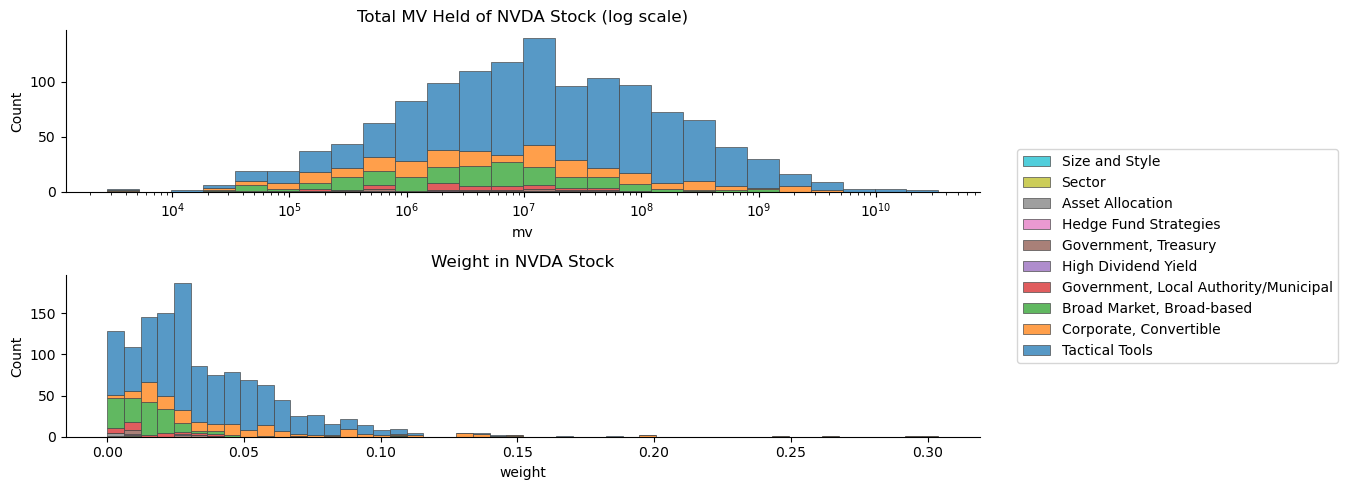

In [8]:
fig, axs= plt.subplots(2,1,figsize=(10, 5))
sns.despine(fig)

sns.histplot(
    df,
    x="mv", hue="category",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
    ax= axs[0]
)
axs[0].legend().set_visible(False)
axs[0].set_title('Total MV Held of NVDA Stock (log scale)')
sns.histplot(
    df,
    x="weight", hue="category",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    ax= axs[1]
)
axs[1].legend().set_visible(False)
axs[1].set_title('Weight in NVDA Stock')
fig.legend(labels=list(df['category'].unique()),
                    loc = 'lower right',
                    bbox_to_anchor=(1.35, .25),)
plt.tight_layout()

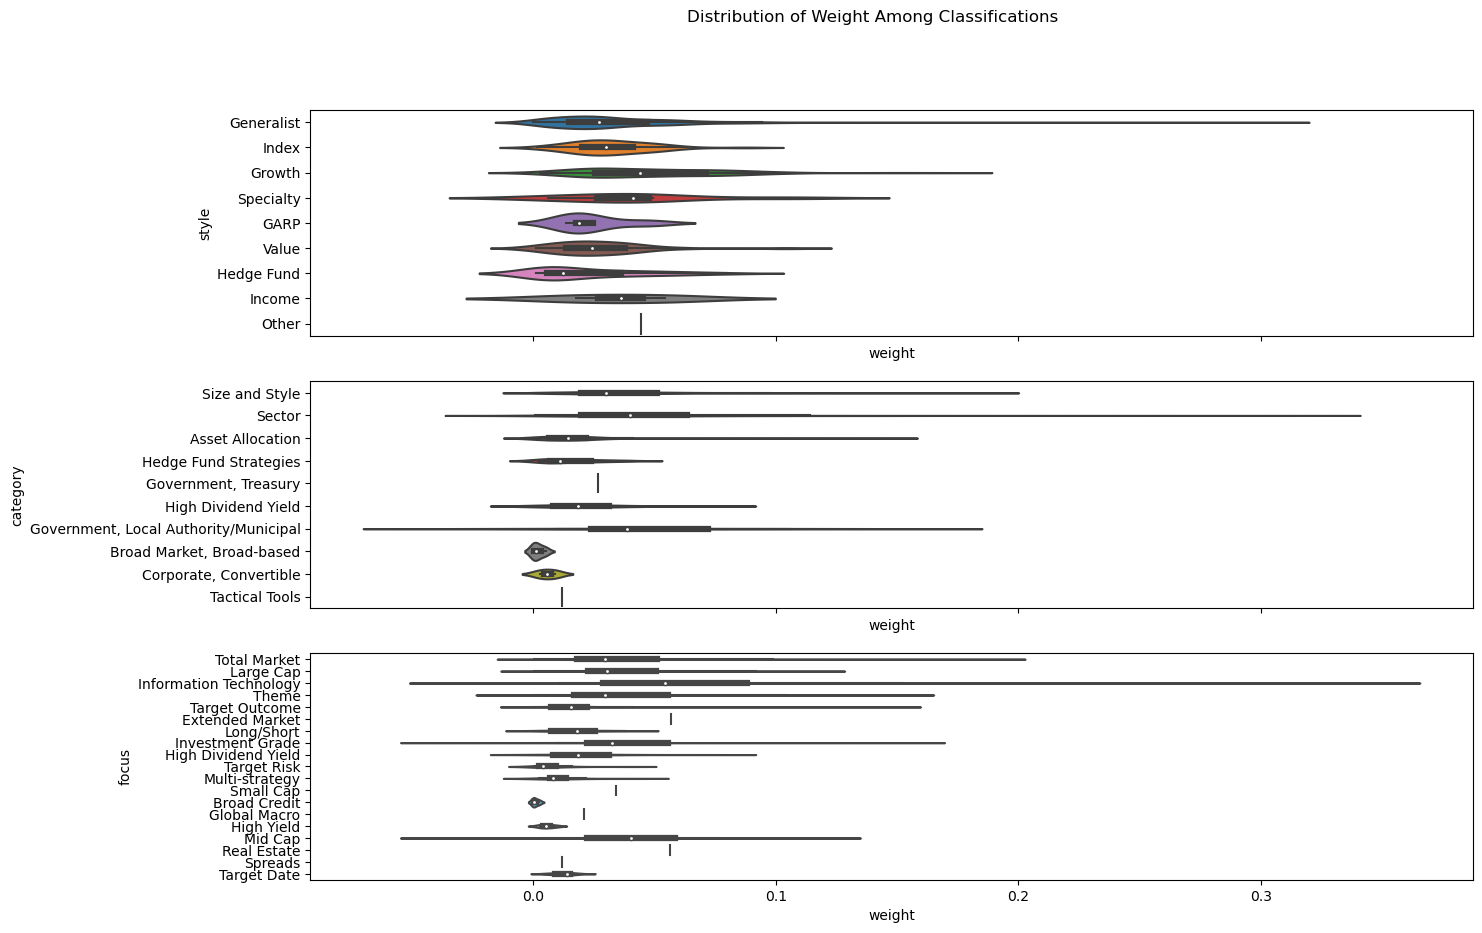

In [9]:
fig,axs= plt.subplots(3,1,figsize =(15,10),sharex=True)

sns.violinplot(data=df, y="style", x="weight",orient = 'h',ax = axs[0])

sns.violinplot(data=df, y="category", x="weight",orient = 'h',ax = axs[1])

sns.violinplot(data=df, y="focus", x="weight",orient = 'h',ax = axs[2])

plt.suptitle('Distribution of Weight Among Classifications')
plt.show()

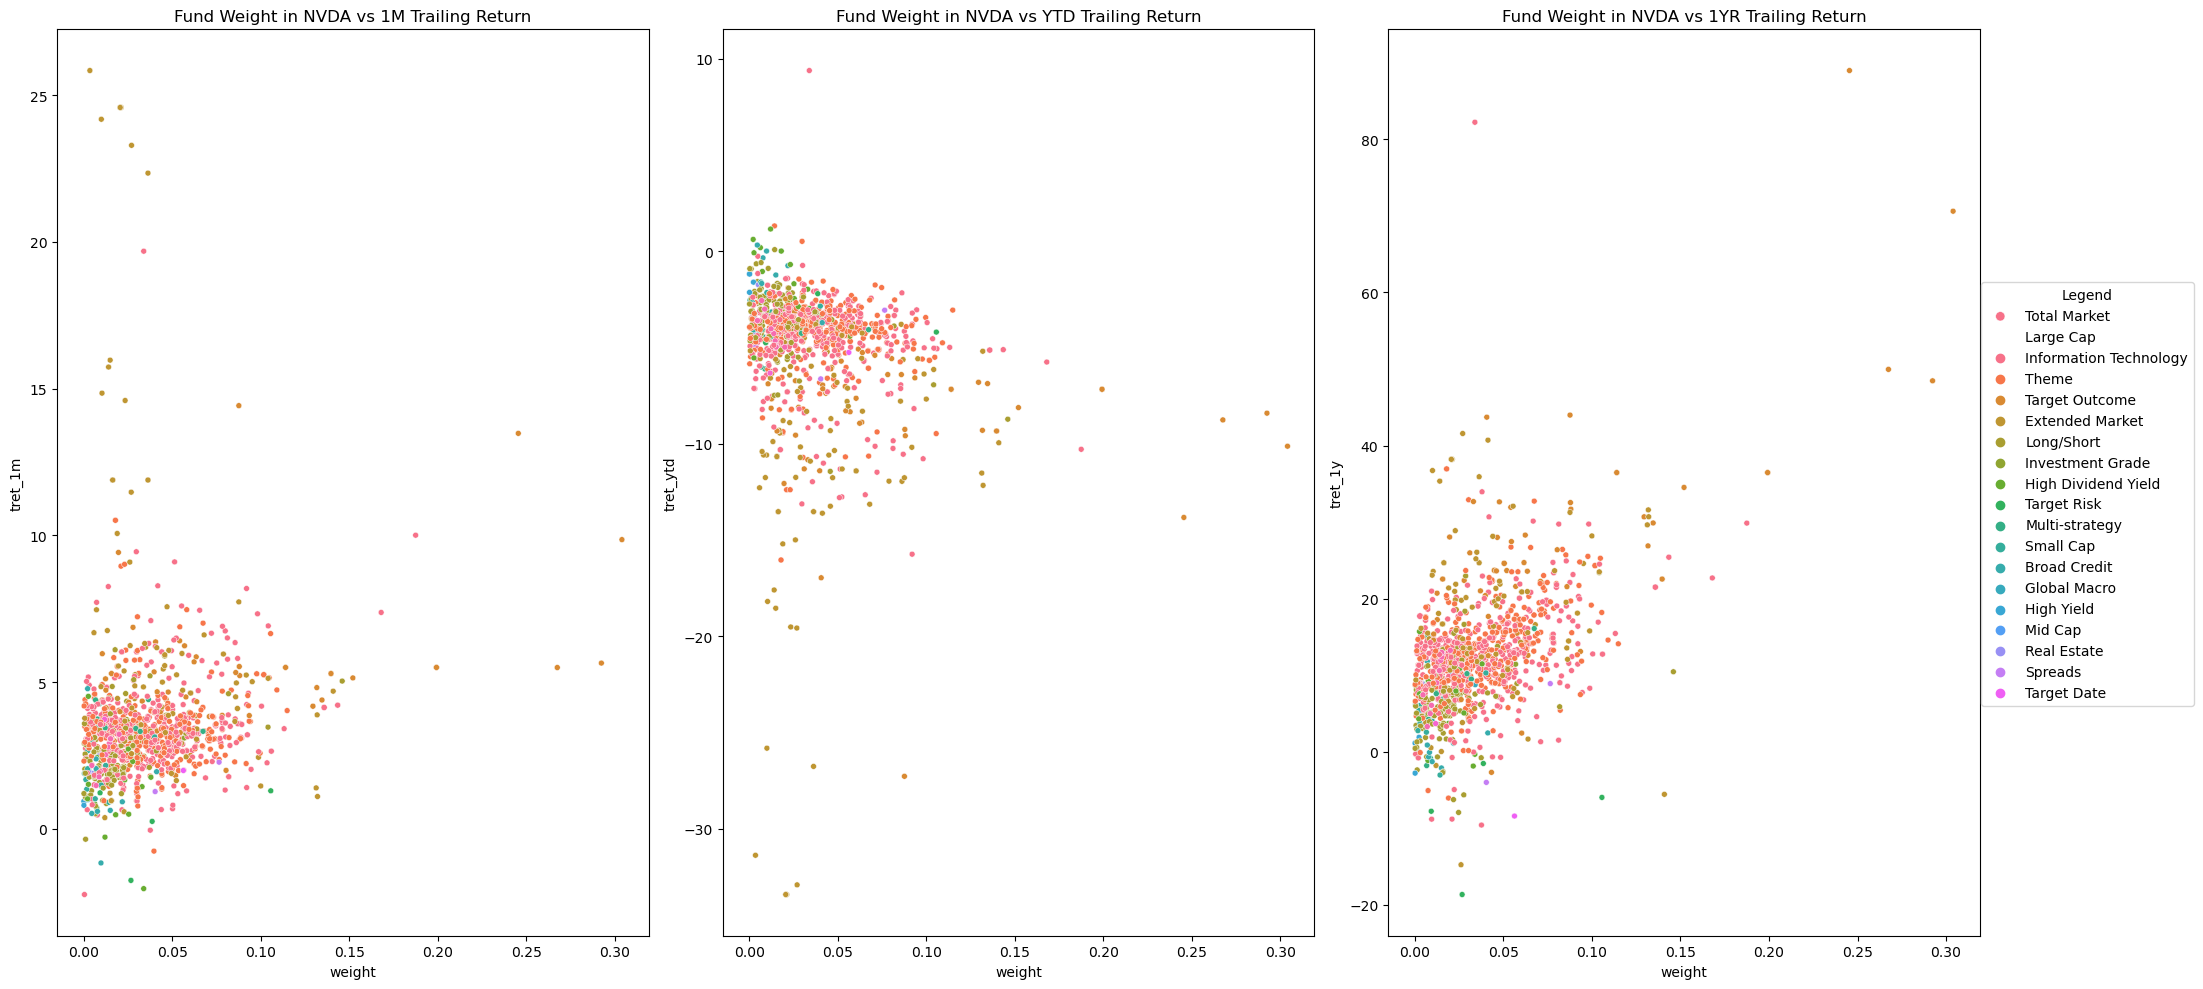

In [10]:
fig,axs= plt.subplots(1,3,figsize =(20,10))

sns.scatterplot(data= df,y='tret_1m',x ='weight',ax = axs[0],hue = 'focus',size = 'aum')
axs[0].set_title('Fund Weight in NVDA vs 1M Trailing Return')

sns.scatterplot(data= df,y='tret_ytd',x ='weight',ax = axs[1],hue = 'focus',size = 'aum')
axs[1].set_title('Fund Weight in NVDA vs YTD Trailing Return')

sns.scatterplot(data= df,y='tret_1y',x ='weight',ax = axs[2],hue='focus',size = 'aum')
axs[2].set_title('Fund Weight in NVDA vs 1YR Trailing Return')

fig.legend(labels=list(df['focus'].unique()),   # The labels for each line
           loc="center right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Legend", # Title for the legend,
           bbox_to_anchor=(1.1, 0.5),
           )
# turn off the legend of each subplot
for ax in axs:
    ax.legend().set_visible(False)


plt.tight_layout()

In [11]:
df[df['weight']>.25]

,hldr_name,mv,DATE,style,fund_family,ticker,aum,weight,category,focus,niche,tret_1m,tret_ytd,tret_1y
hldr_id,,,,,,,,,,,,,,
M4001506,Fidelity Select Port. - Semiconductors Portfolio,3.005407e+09,20230731,Generalist,Fidelity Select Funds,FSELX,1.123633e+10,0.267472,Sector,Information Technology,Semiconductors,5.49361,-8.77056,49.9536
M4014606,Fidelity Advisor Series VII - Semiconductors Fund,3.995923e+08,20230731,Generalist,Fidelity Advisor Funds,FIKGX,1.366666e+09,0.292385,Sector,Information Technology,Semiconductors,5.64580,-8.41917,48.4563
M4008067,ProFunds - Semiconductor Ultrasector,3.000142e+07,20230731,Generalist,ProFunds Funds,SMPSX,9.869275e+07,0.303988,Sector,Information Technology,Semiconductors,9.85305,-10.13550,70.6218


In [12]:
df[df['tret_1m']>20]

,hldr_name,mv,DATE,style,fund_family,ticker,aum,weight,category,focus,niche,tret_1m,tret_ytd,tret_1y
hldr_id,,,,,,,,,,,,,,
M4268049,Global X Blockchain ETF,2209814.41,20230731,Generalist,Global X Funds,BKCH,1.049266e+08,0.021061,Sector,Theme,Blockchain,24.5785,-33.4201,38.1965
M4268049,Global X Blockchain ETF,2209814.41,20230731,Generalist,Global X Funds,BKCH,1.049266e+08,0.021061,Sector,Theme,Blockchain,24.5785,-33.4201,38.1965
M20126878,Valkyrie Bitcoin Miners ETF,650467.68,20230731,Index,Valkyrie Funds,WGMI,2.409224e+07,0.026999,Sector,Theme,Digital Economy,23.2898,-32.9177,41.5711
M4279819,iShares Blockchain & Tech ETF,340654.41,20230731,Generalist,iShares Funds,IBLC,9.388807e+06,0.036283,Sector,Theme,Blockchain,22.3423,-26.7657,35.9211
M4278587,Global X ETFs ICAV - Blockchain UCITS ETF,128037.46,20230731,Generalist,Other,BKCH,6.219023e+06,0.020588,Sector,Theme,Blockchain,24.5785,-33.4201,38.1965
M4278587,Global X ETFs ICAV - Blockchain UCITS ETF,128037.46,20230731,Generalist,Other,BKCH,6.219023e+06,0.020588,Sector,Theme,Blockchain,24.5785,-33.4201,38.1965
M4276389,First Trust SkyBridge Crypto Industry & Digita...,80841.17,20230731,Hedge Fund,First Trust Funds,CRPT,2.324108e+07,0.003478,Sector,Theme,Digital Economy,25.8377,-31.3802,16.1157
M4276911,Invesco Alerian Galaxy Crypto Economy ETF,52336.48,20230731,Generalist,Invesco Funds,SATO,5.266139e+06,0.009938,Sector,Theme,Digital Economy,24.1779,-25.8194,36.7311


In [13]:
df_g  =df.groupby('niche').agg({'weight':'mean',
                        'tret_1m':'mean',
                        'tret_ytd':'mean',
                        'tret_1y':'mean'})

df_g

,weight,tret_1m,tret_ytd,tret_1y
niche,,,,
2015,0.006993,1.473930,-2.569820,3.275670
2020,0.008659,1.768880,-3.012750,4.965720
2025,0.009381,1.951220,-3.349270,6.047570
2030,0.004589,2.158270,-3.609160,7.422440
2035,0.012282,2.520260,-4.038630,8.988880
2040,0.013806,2.785270,-4.283210,10.587200
2045,0.014598,2.913450,-4.662780,11.922700
2050,0.015168,3.054110,-4.911100,12.358700
2055,0.015153,3.083690,-4.957260,12.938500


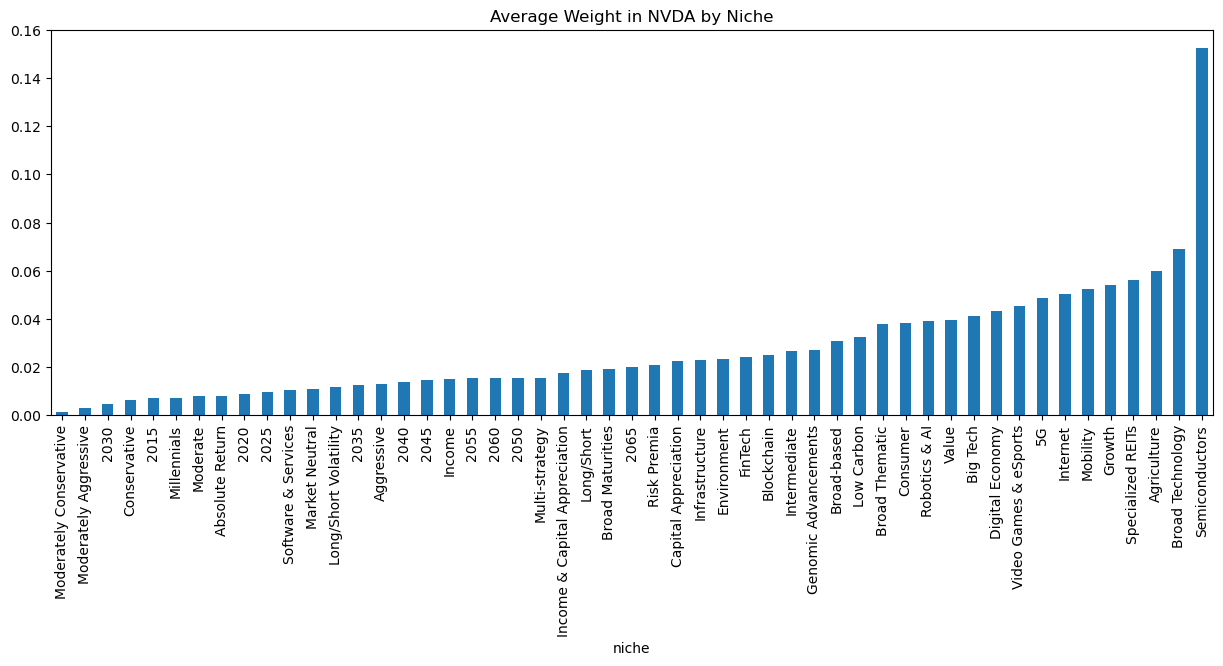

In [14]:
df_g['weight'].sort_values().plot(kind = 'bar',figsize =(15,5))
plt.title('Average Weight in NVDA by Niche')
plt.show()

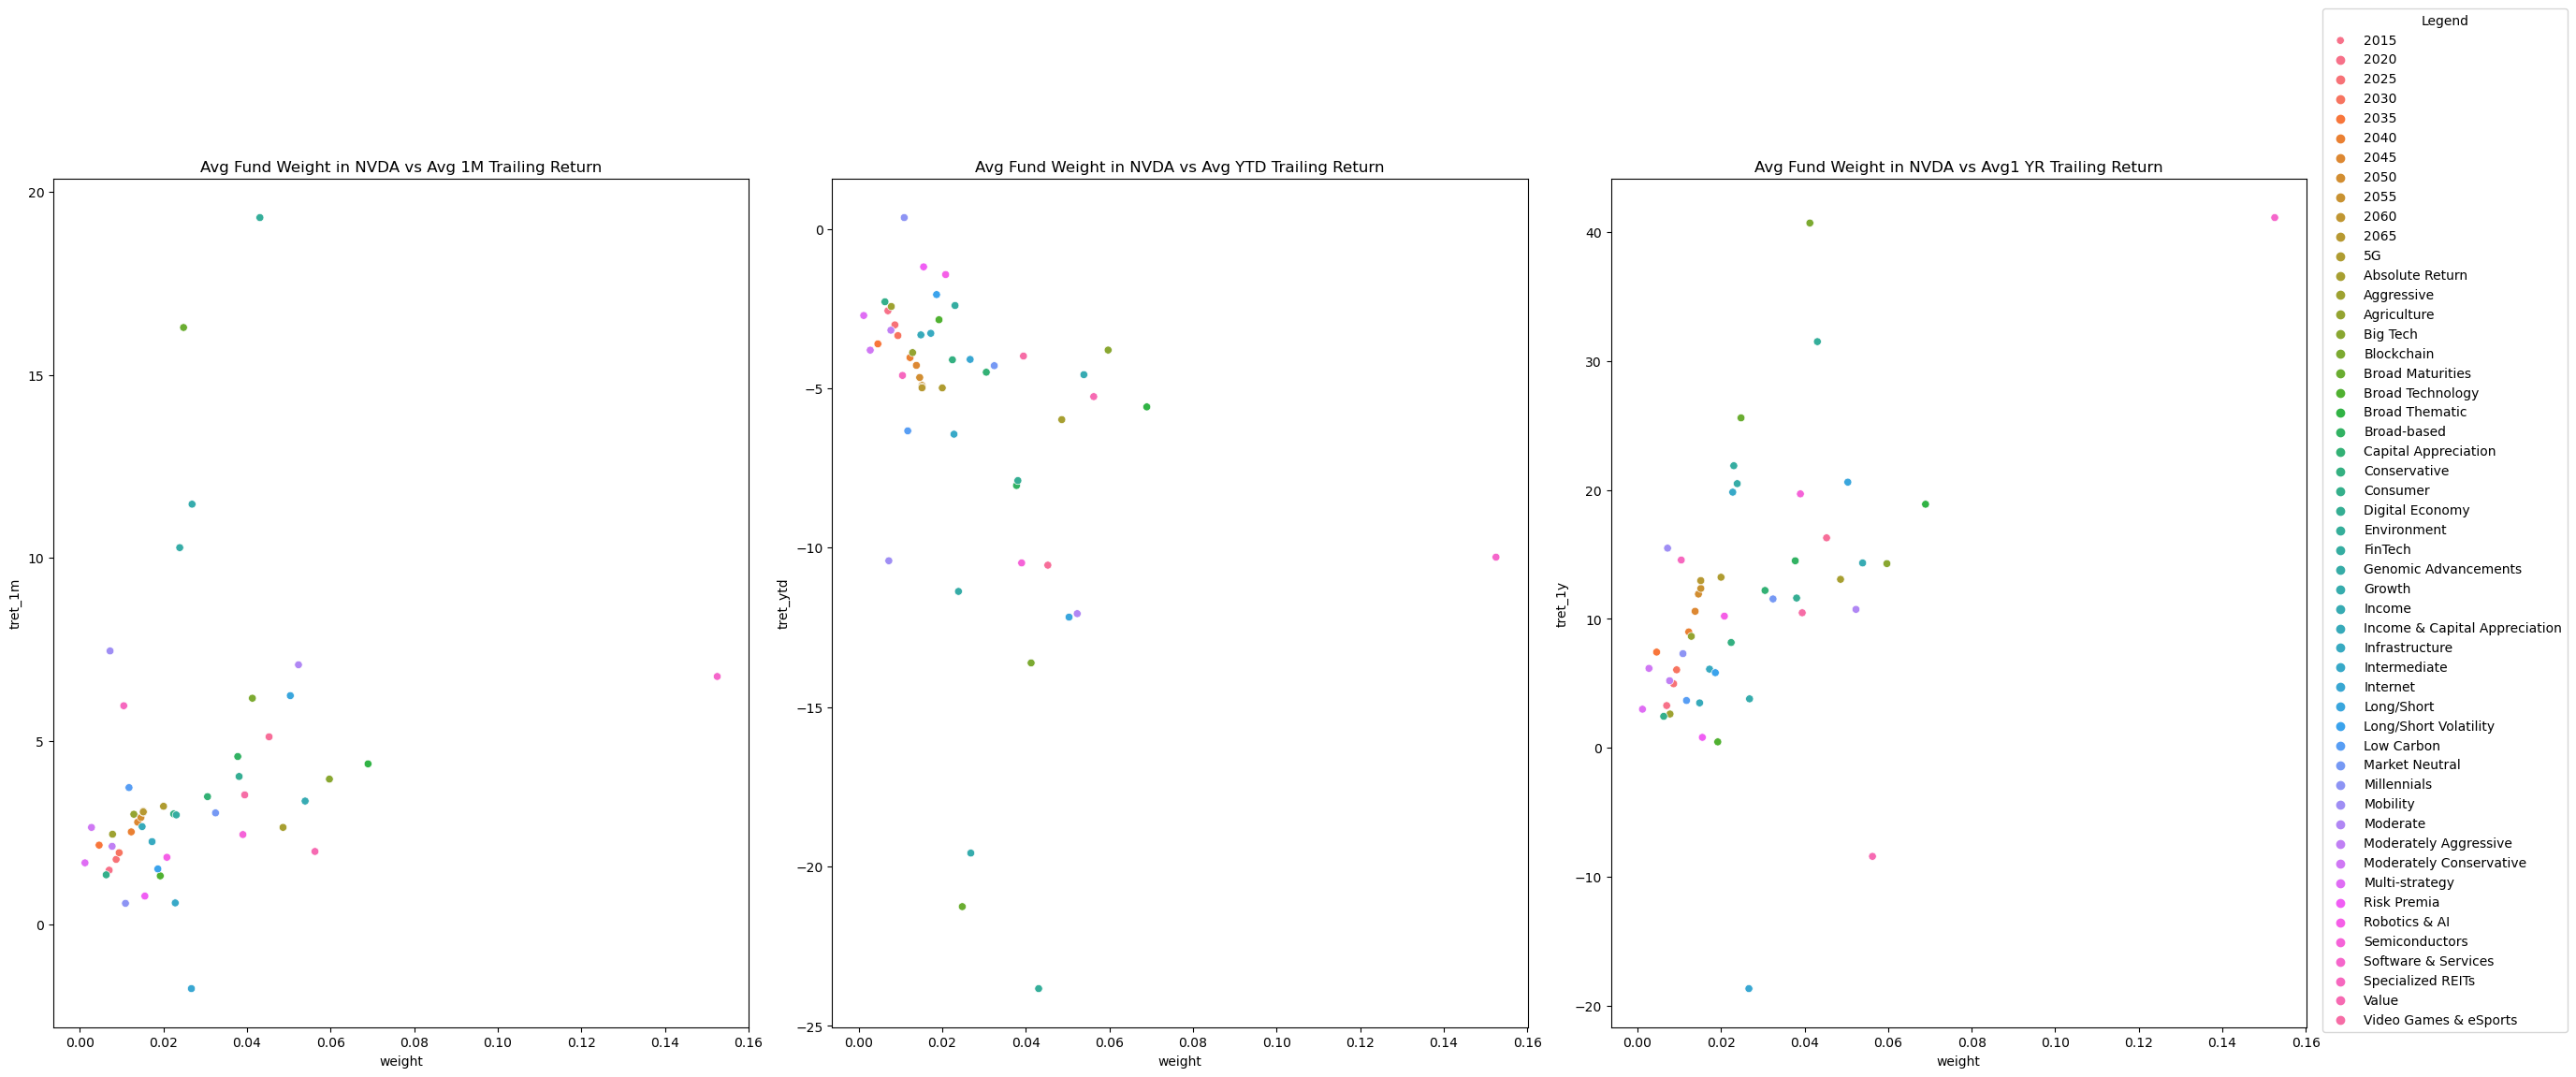

In [15]:
fig,axs= plt.subplots(1,3,figsize =(25,10))

sns.scatterplot(data= df_g,y='tret_1m',x ='weight',ax = axs[0],hue = list(df_g.index))
axs[0].set_title('Avg Fund Weight in NVDA vs Avg 1M Trailing Return')

sns.scatterplot(data= df_g,y='tret_ytd',x ='weight',ax = axs[1],hue = list(df_g.index))
axs[1].set_title('Avg Fund Weight in NVDA vs Avg YTD Trailing Return')

sns.scatterplot(data= df_g,y='tret_1y',x ='weight',ax = axs[2],hue = list(df_g.index))
axs[2].set_title('Avg Fund Weight in NVDA vs Avg1 YR Trailing Return')

fig.legend(labels=list(df_g.index),   # The labels for each line
           loc="center right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Legend", # Title for the legend,
           bbox_to_anchor=(1.1, .6),
           )
# turn off the legend of each subplot
for ax in axs:
    ax.legend().set_visible(False)


plt.tight_layout()